<div style="text-align: center; font-size: 32px;">
  *** THIS IS A WORK IN PROCESS ***
</div>

# Smart Device Usage Analysis

In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; } </style>"))

## Table of Contents

## Introduction

Bellabeat is a high-tech manufacturer of health-focused products for women. Since its founding, Bellabeat has experienced rapid growth and has the potential to become a major player in the global smart device market. While our current marketing strategy primarily focuses on digital channels, we also invest on a smaller scale in traditional media.

The Chief Creative Officer believes that analyzing consumer data could reveal new growth opportunities. The Marketing Analytics Team has been tasked with analyzing smart device data to gain insights into how consumers are using it. These insights will then be used to inform and refine future marketing strategies.
  <br>
  <br>

<div style="text-align: center;">
  <div style="display: inline-block; border: 1px solid; padding: 10px;">
    <strong><em>Business Task:</em></strong><br>
    <em>Analyze smart device usage data to understand consumer behavior, uncover opportunities for growth, and guide marketing strategies.</em>
  </div>
</div>

  <br>
  <br>
For this analysis, we are using publicly available data from Fitbit Fitness Trackers. The dataset includes daily metrics (such as steps, distance, activity intensities, calories burned, and sleep time) as well as hourly data (calories burned, heart rate, and steps), spanning from April 11, 2016, to May 12, 2016. The complete dataset contains 18 CSV files, of which 8 were utilized in this analysis.

## Initial Data Exploration

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect

import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

In [3]:
# Load CSV files into the SQLite database

engine = create_engine('sqlite:///:memory:')

data_path = 'data/'
csv_files = glob.glob(f"{data_path}/*.csv")


for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    table_name = file_name.split('_')[0]
    df.to_sql(table_name, engine, index=False, if_exists='replace')

In [4]:
inspector = inspect(engine)

# Get the names of all tables in the database
table_names = inspector.get_table_names()

print(table_names)
print(len(table_names))

['dailyActivity', 'dailyCalories', 'dailyIntensities', 'dailySteps', 'heartrate', 'hourlyCalories', 'hourlyIntensities', 'hourlySteps', 'minuteCaloriesNarrow', 'minuteCaloriesWide', 'minuteIntensitiesNarrow', 'minuteIntensitiesWide', 'minuteMETsNarrow', 'minuteSleep', 'minuteStepsNarrow', 'minuteStepsWide', 'sleepDay', 'weightLogInfo']
18


We have 18 tables. Let's examine their columns and data types to better understand the available data and whether or not we need to update data types for the relevant analyses. We will exclude the tables in wide format and the tables that show the data by the minute.

In [5]:
# Including only the tables that do not have 'wide' in their name
relevant_tables = [table_name for table_name in table_names if 'wide' not in table_name.lower()]
relevant_tables = [table_name for table_name in relevant_tables if 'minute' not in table_name.lower()]
relevant_tables

['dailyActivity',
 'dailyCalories',
 'dailyIntensities',
 'dailySteps',
 'heartrate',
 'hourlyCalories',
 'hourlyIntensities',
 'hourlySteps',
 'sleepDay',
 'weightLogInfo']

In [6]:
tables_info = {}

for table_name in relevant_tables:
    columns = inspector.get_columns(table_name)
    column_info = {col['name']: col['type'] for col in columns}
    tables_info[table_name] = column_info

for table_name, columns in tables_info.items():
    print(f'Table: {table_name}')
    for col_name, col_type in columns.items():
        print(f'{col_name} --> {col_type}')
    print()
    print()

Table: dailyActivity
Id --> BIGINT
ActivityDate --> TEXT
TotalSteps --> BIGINT
TotalDistance --> FLOAT
TrackerDistance --> FLOAT
LoggedActivitiesDistance --> FLOAT
VeryActiveDistance --> FLOAT
ModeratelyActiveDistance --> FLOAT
LightActiveDistance --> FLOAT
SedentaryActiveDistance --> FLOAT
VeryActiveMinutes --> BIGINT
FairlyActiveMinutes --> BIGINT
LightlyActiveMinutes --> BIGINT
SedentaryMinutes --> BIGINT
Calories --> BIGINT


Table: dailyCalories
Id --> BIGINT
ActivityDay --> TEXT
Calories --> BIGINT


Table: dailyIntensities
Id --> BIGINT
ActivityDay --> TEXT
SedentaryMinutes --> BIGINT
LightlyActiveMinutes --> BIGINT
FairlyActiveMinutes --> BIGINT
VeryActiveMinutes --> BIGINT
SedentaryActiveDistance --> FLOAT
LightActiveDistance --> FLOAT
ModeratelyActiveDistance --> FLOAT
VeryActiveDistance --> FLOAT


Table: dailySteps
Id --> BIGINT
ActivityDay --> TEXT
StepTotal --> BIGINT


Table: heartrate
Id --> BIGINT
Time --> TEXT
Value --> BIGINT


Table: hourlyCalories
Id --> BIGINT
Act

We can see that the columns with dates, days, hours and times are `TEXT` type. We will cast them when necessary.

In [7]:
# Unique number of users in each table

for table in relevant_tables:
    query = f"""
    SELECT COUNT(DISTINCT id) as id_cnt
    FROM {table}
    """
    
    df = pd.read_sql_query(query, engine)
    print(f'Table {table}: {df.iloc[0,0]} distinct users')
    print()

Table dailyActivity: 33 distinct users

Table dailyCalories: 33 distinct users

Table dailyIntensities: 33 distinct users

Table dailySteps: 33 distinct users

Table heartrate: 14 distinct users

Table hourlyCalories: 33 distinct users

Table hourlyIntensities: 33 distinct users

Table hourlySteps: 33 distinct users

Table sleepDay: 24 distinct users

Table weightLogInfo: 8 distinct users



In [29]:
query = """
SELECT
    activityDate,
    CASE WHEN activityDate LIKE '%d/%m/%Y' THEN strftime('%Y-%m-%d', activityDate)
        ELSE NULL END AS formatted_date
FROM dailyActivity;
"""

df = pd.read_sql_query(query, engine)
df

,ActivityDate,formatted_date
0,12/04/2016,None
1,13/04/2016,None
2,14/04/2016,None
3,15/04/2016,None
4,16/04/2016,None
...,...,...
935,08/05/2016,None
936,09/05/2016,None
937,10/05/2016,None
938,11/05/2016,None


In [8]:
# Checking date ranges for each table

date_keywords = ['date', 'day', 'hour', 'time']

for table in relevant_tables:
    columns = inspector.get_columns(table)
    for col in columns:
        if any(keyword in col['name'].lower() for keyword in date_keywords):
            col_name = col['name']
            break

    query = f"""
    SELECT 
        MIN({col_name}) AS min_date,
        MAX({col_name}) AS max_date
    FROM {table}
    """

    df = pd.read_sql_query(query, engine)
    print(table)
    print(df)
    print()

dailyActivity
     min_date    max_date
0  01/05/2016  30/04/2016

dailyCalories
     min_date    max_date
0  2016-04-12  2016-05-12

dailyIntensities
     min_date    max_date
0  2016-04-12  2016-05-12

dailySteps
     min_date    max_date
0  2016-04-12  2016-05-12

heartrate
                min_date             max_date
0  4/12/2016 10:00:00 AM  5/9/2016 9:59:59 PM

hourlyCalories
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 15:00:00

hourlyIntensities
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 15:00:00

hourlySteps
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 15:00:00

sleepDay
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 00:00:00

weightLogInfo
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 00:00:00



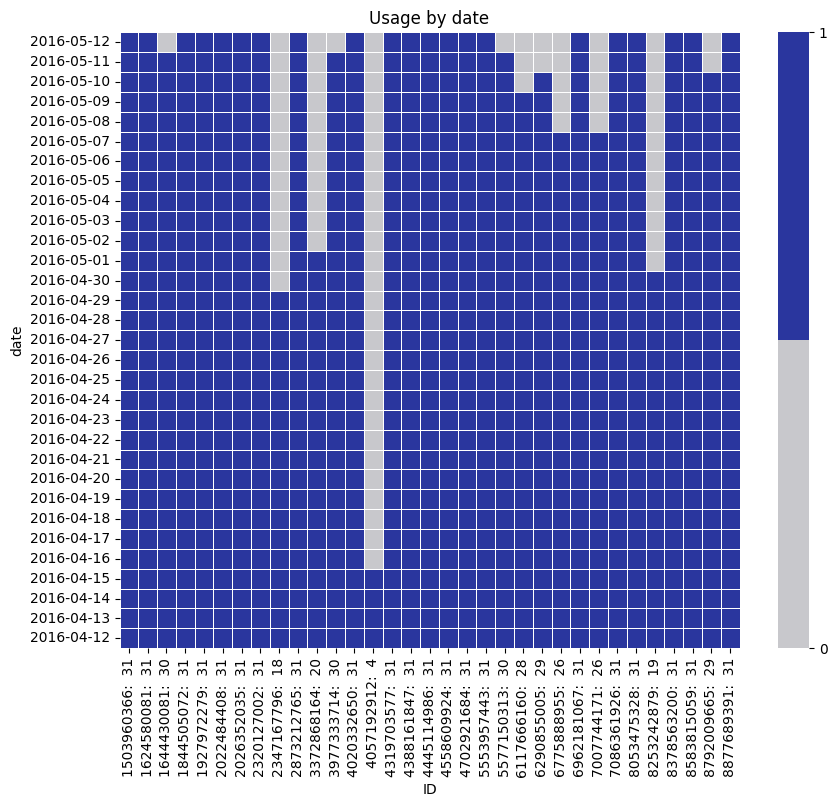

In [19]:
query = """
SELECT 
    id as ID,
    ActivityDay as date
FROM
    dailyCalories
ORDER BY
    2 DESC
"""

df = pd.read_sql_query(query, engine)

# Get matrix of 1s and 0s for the usage of the device by user id
dates_used = df.pivot_table(
    index = 'date',
    columns='ID',
    aggfunc=len,
    fill_value = 0
)

dates_used = dates_used.sort_index(ascending=False)

# Adding total days used for the x-label
sum_usage = dates_used.sum()
x_labels = [f'{col}:  {sum_usage[col]}' for col in dates_used.columns]

# Colors
binary_palette = sns.color_palette(['#c8c8cc', '#2a369e']) 

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data=dates_used, linewidths=.5, cbar=True, cmap=binary_palette, cbar_kws={'ticks': [0, 1]})
plt.title("Usage by date")
ax.set_xticklabels(x_labels)

plt.show()

Most users used their devices most days. However, there were users who used it less than 20 days and even one who used it only 4 days. For every user, the usage was continuous — once a user didn't use their device, they stopped using it instead of having gaps in the usage throughout the month.

## Calories Function

In this section we will explore the trends related to the calories burned, based on the data offerd by the devices. 

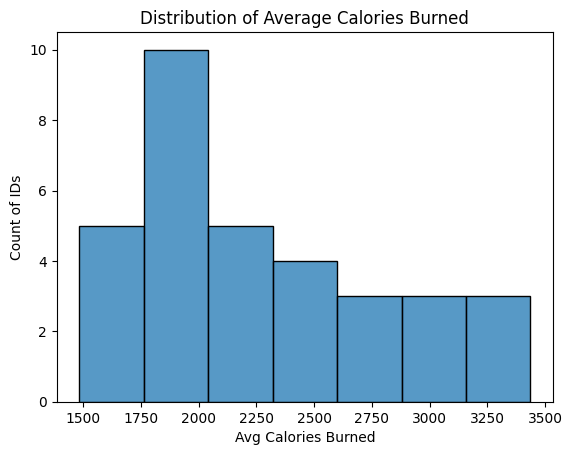

In [10]:
query = """
SELECT
    Id
    ,AVG(calories) as calories_avg
FROM dailyActivity
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df


# Plot histograms of calories burned
ax = sns.histplot(data=df['calories_avg'])

ax.set_title('Distribution of Average Calories Burned')
ax.set_xlabel('Avg Calories Burned')
ax.set_ylabel('Count of IDs')

plt.show()

In [11]:
query = """
WITH average_calories AS (
SELECT
    Id
    ,AVG(calories) as calories_avg
FROM dailyActivity
GROUP BY
    1
)

SELECT
    ROUND(MIN(calories_avg), 2) AS min_avg
    ,ROUND(MAX(calories_avg), 2) AS max_avg
FROM
    average_calories
"""

df = pd.read_sql_query(query, engine)
df

,min_avg,max_avg
0,1483.35,3436.58


The average calories burned range roughly between 1500 and 3500 per user, with around 30 percent of the users burning between 1750 and 2000 calories. Let's examine the average calories burned per day of the week.

In [12]:
query = """
WITH avg_calories_user_dow AS (
SELECT
    Id
    ,strftime('%w', activityDate) as dow
    ,AVG(calories) AS calories_avg
FROM dailyActivity
GROUP BY
    1, 2
)

SELECT
    dow
    ,AVG(calories_avg) AS calories_avg
FROM avg_calories_user_dow
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df

,dow,calories_avg
0,None,2282.44366


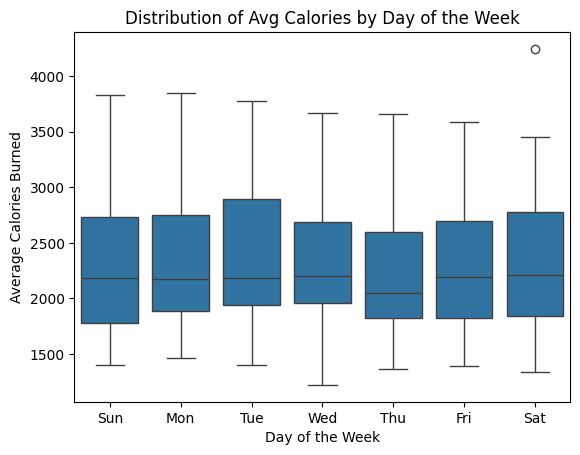

In [31]:
query = """
SELECT
    Id
    ,strftime('%w', activityDay) as dow
    ,AVG(calories) AS calories_avg
FROM dailyCalories
GROUP BY
    1, 2

"""

df = pd.read_sql_query(query, engine)


# Boxplot of average calories burned by day of the week
ax = sns.boxplot(data=df, x='dow', y='calories_avg')

ax.set_title('Distribution of Avg Calories by Day of the Week')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Calories Burned')

ax.set_xticks(range(7))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

plt.show()

The average for each day of the week seem to be similar, with Thursday presenting the lower average. However, the average for each day of the week is above 2000, which is around the average of calories burned for moderately active people based on <a href='https://health.clevelandclinic.org/calories-burned-in-a-day]'>Clinic of Cleveland</a>.

Let's also look at the average calories burned by time of the day.

In [34]:
query = """
WITH avg_calories_user_hour AS (
SELECT
    Id
    ,strftime('%h', activityDay) as hour
    ,AVG(calories) AS calories_avg
FROM dailyCalories
GROUP BY
    1, 2
)

SELECT
    hour
    ,AVG(calories_avg) AS calories_avg
FROM avg_calories_user_hour
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df

,hour,calories_avg
0,None,2282.44366


In [35]:
query = """
SELECT
    *
FROM dailyActivity
LIMIT 1
"""

df = pd.read_sql_query(query, engine)
df

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,12/04/2016,13162,8.5,8.5,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985


'dailyActivity',
 'dailyCalories',
 'dailyIntensities',
 'dailySteps',
 'heartrate',
 'hourlyCalories',
 'hourlyIntensities',
 'hourlySteps',
 'sleepDay',
 'weightLogInfo']